<a href="https://colab.research.google.com/github/Kaavyyaaaa/Facial-Recognition-/blob/main/1_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# <--- Training without Disgusting expression. --->**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# SECTION 0: SETUP AND CONFIGURATION

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

# --- Configuration Variables ---
# Original 7-class dataset (local copy)
ORIGINAL_TRAIN_DIR = '/content/dataset/train'
ORIGINAL_TEST_DIR = '/content/dataset/test'
# New 6-class dataset paths
SIX_CLASS_TRAIN_DIR = '/content/dataset_6_classes/train'
SIX_CLASS_TEST_DIR = '/content/dataset_6_classes/test'
# New output directory for this experiment
OUTPUT_DIR = "/content/drive/MyDrive/ML Project/FacialRecognitionModels/6_Class_Experiment"

# Model parameters
IMG_SIZE = 96
BATCH_SIZE = 64

In [ ]:

#Section 1: COPY DATASET FROM DRIVE TO COLAB
%%bash

# Define the new directories for the 6-class experiment
NEW_TRAIN_DIR='/content/dataset_6_classes/train'
NEW_TEST_DIR='/content/dataset_6_classes/test'

mkdir -p "$NEW_TRAIN_DIR"
mkdir -p "$NEW_TEST_DIR"

# List of the 6 classes you want to keep
CLASSES_TO_KEEP="angry fear happy neutral sad surprise"

# --- Copy the training data, excluding 'disgust' ---
echo "Copying 6-class training data..."
# This assumes your original data is in /content/dataset/train
for CLASS in $CLASSES_TO_KEEP; do
  cp -r "/content/dataset/train/$CLASS" "$NEW_TRAIN_DIR/"
done

# --- Copy the testing data, excluding 'disgust' ---
echo "Copying 6-class testing data..."
# This assumes your original data is in /content/dataset/test
for CLASS in $CLASSES_TO_KEEP; do
  cp -r "/content/dataset/test/$CLASS" "$NEW_TEST_DIR/"
done

echo "Done creating 6-class dataset."

Copying 6-class training data...
Copying 6-class testing data...
Done creating 6-class dataset.


In [ ]:

# SECTION 2: CREATE DATA GENERATORS
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    SIX_CLASS_TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    SIX_CLASS_TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 28173 images belonging to 6 classes.
Found 6281 images belonging to 6 classes.


In [ ]:
# ==============================================================================
# SECTION 3-5: BUILD AND TRAIN THE MODEL
# ==============================================================================
print("\n--- Building MobileNetV2 Model for 6 Classes ---")
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(train_generator.num_classes, activation='softmax')(x) # num_classes will now be 6
model = Model(inputs=base_model.input, outputs=preds)
print("Model built successfully.")

# --- PHASE 1 TRAINING ---
print("\n--- Starting Phase 1 Training ---")
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop_p1 = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
reduce_lr_p1 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, verbose=1)

history_p1 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stop_p1, reduce_lr_p1],
    verbose=1
)

# --- PHASE 2 TRAINING (FINE-TUNING) ---
print("\n--- Starting Phase 2 Fine-Tuning ---")
base_model.trainable = True
fine_tune_at = 60 # Using the successful aggressive setting
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
best_model_path = os.path.join(OUTPUT_DIR, "6class_best_model.keras")
checkpoint = ModelCheckpoint(filepath=best_model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop_p2 = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
reduce_lr_p2 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1)

history_p2 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    initial_epoch=len(history_p1.epoch),
    callbacks=[checkpoint, early_stop_p2, reduce_lr_p2],
    verbose=1
)

print("\n--- Training complete. ---")


--- Building MobileNetV2 Model for 6 Classes ---
Model built successfully.

--- Starting Phase 1 Training ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 344s 762ms/step - accuracy: 0.3249 - loss: 1.7158 - val_accuracy: 0.4358 - val_loss: 1.4657 - learning_rate: 0.0010
Epoch 2/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 358s 812ms/step - accuracy: 0.4009 - loss: 1.5039 - val_accuracy: 0.4421 - val_loss: 1.4298 - learning_rate: 0.0010
Epoch 3/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 320s 725ms/step - accuracy: 0.4169 - loss: 1.4677 - val_accuracy: 0.4359 - val_loss: 1.4296 - learning_rate: 0.0010
Epoch 4/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 359s 810ms/step - accuracy: 0.4222 - loss: 1.4600 - val_accuracy: 0.4452 - val_loss: 1.4132 - learning_rate: 0.0010
Epoch 5/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 325s 735ms/step - accuracy: 0.4244 - loss: 1.4513 - val_accuracy: 0.4485 - val_loss: 1.4019 - learning_rate: 0.0010
Epoch 6/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 377s 725ms/step - accuracy: 0.4315 - loss: 1.4384 - val_accuracy: 0.4463 - val_loss: 1.4088 - learning_rate: 0.0010
Epoch 7/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy


--- Saving Final Model and History ---
Final model state saved at: /content/drive/MyDrive/ML Project/FacialRecognitionModels/6_Class_Experiment/6class_final_model.keras
Full training history saved at: /content/drive/MyDrive/ML Project/FacialRecognitionModels/6_Class_Experiment/6class_training_history.csv

--- Evaluating Best Model Performance ---
99/99 ━━━━━━━━━━━━━━━━━━━━ 51s 492ms/step

--- Classification Report (Accuracy, Precision, Recall, F1-Score) ---
              precision    recall  f1-score   support

       angry       0.65      0.14      0.23       953
        fear       0.52      0.13      0.20      1021
       happy       0.74      0.78      0.76      1763
     neutral       0.21      0.64      0.31       477
         sad       0.39      0.61      0.48      1242
    surprise       0.77      0.54      0.63       825

    accuracy                           0.50      6281
   macro avg       0.55      0.47      0.44      6281
weighted avg       0.59      0.50      0.48      

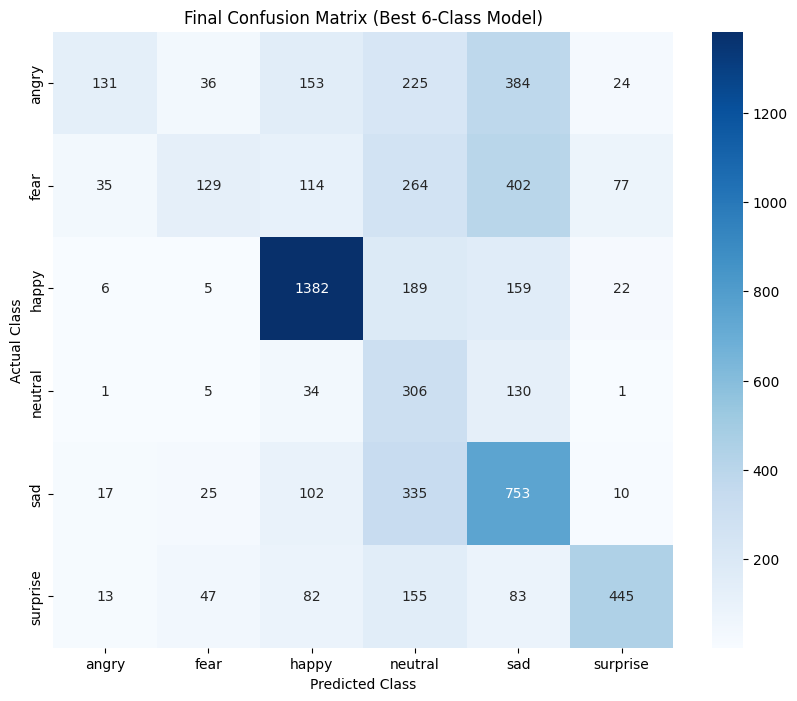


--- Plotting Training Curves ---


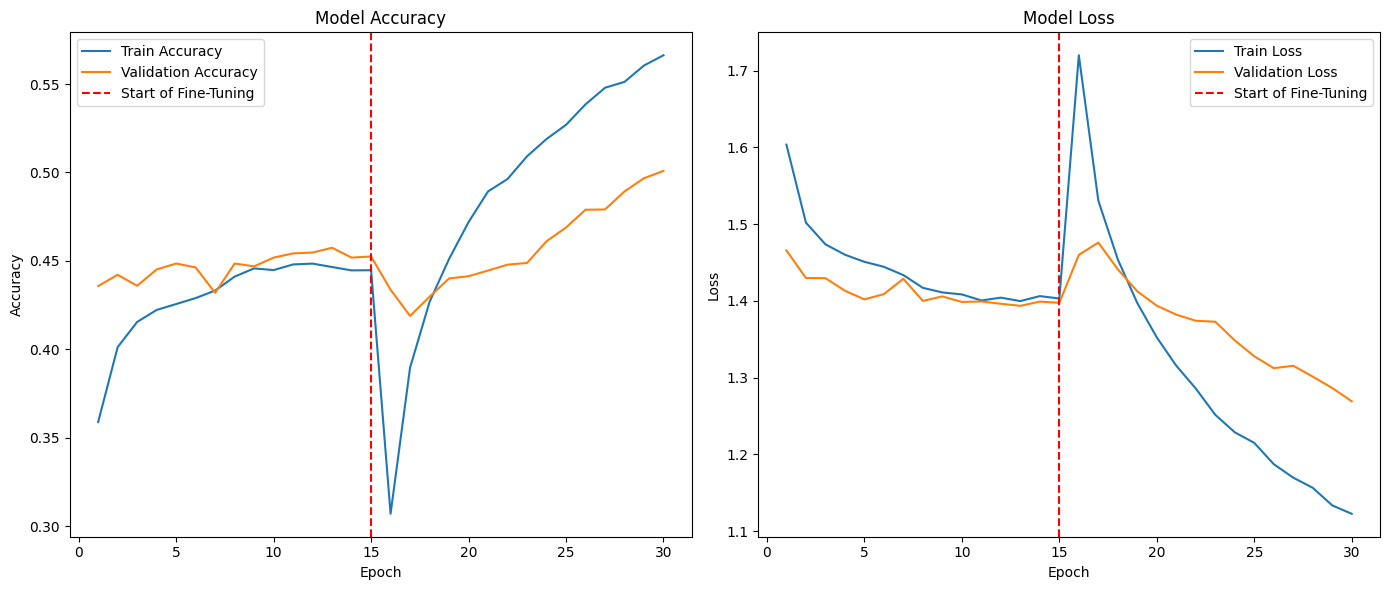


--- All tasks complete. ---


In [ ]:

# SECTION 6-8: SAVE, EVALUATE, AND PLOT

import seaborn as sns
import matplotlib.pyplot as plt


print("\n--- Saving Final Model and History ---")
final_model_path = os.path.join(OUTPUT_DIR, "6class_final_model.keras")
model.save(final_model_path)
print(f"Final model state saved at: {final_model_path}")

history_df_p1 = pd.DataFrame(history_p1.history)
history_df_p2 = pd.DataFrame(history_p2.history)
full_history_df = pd.concat([history_df_p1, history_df_p2], ignore_index=True)
full_history_df.index += 1
history_path = os.path.join(OUTPUT_DIR, "6class_training_history.csv")
full_history_df.to_csv(history_path, index_label='epoch')
print(f"Full training history saved at: {history_path}")

print("\n--- Evaluating Best Model Performance ---")
best_model = tf.keras.models.load_model(best_model_path)

test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\n--- Classification Report (Accuracy, Precision, Recall, F1-Score) ---")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Final Confusion Matrix (Best 6-Class Model)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

print("\n--- Plotting Training Curves ---")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(full_history_df['accuracy'], label='Train Accuracy')
plt.plot(full_history_df['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=len(history_p1.epoch), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(full_history_df['loss'], label='Train Loss')
plt.plot(full_history_df['val_loss'], label='Validation Loss')
plt.axvline(x=len(history_p1.epoch), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- All tasks complete. ---")